# Forecasting Inflation with Recurrent Neural Network

## Introduction

Using an Inflation dataset extracted from Bloomberg from September-9-1951 to September-9-2023 to train the LSTM model to forecast inflation.

The project requires Pandas and Numpy for data manipulation, Matplotlib.pyplot for data visualization, scikit-learn for scaling and evaluation, and TensorFlow for modeling. We will also set seeds for reproducibility.

### What is a Recurrent Neural Network (RNN)?

A Recurrent Neural Network (RNN) is a type of artificial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, or numerical time series data emanating from stocks, sensors, or auctions. Unlike traditional neural networks, RNNs have loops within them, allowing information to persist. This memory-like feature makes RNNs particularly suitable for tasks where the context or sequence of the data is important.

### How RNNs are Useful for Predicting Stock Prices and Inflation

#### Predicting Stock Prices

Stock prices are influenced by a myriad of factors including economic indicators, company performance, and market sentiment. These factors do not exist in isolation; they are part of a complex, dynamic system that evolves over time. RNNs, with their ability to process sequences of data, can capture these temporal dependencies. By training on historical stock price data and associated factors, RNNs can learn to predict future stock prices. The predictions can be based on patterns that the network has identified in the data, which might not be immediately apparent to human analysts.

#### Predicting Inflation

Inflation is another complex, dynamic process influenced by various factors such as supply and demand, money supply, and fiscal policy. Like stock prices, inflation rates follow a temporal sequence and are affected by past and present economic conditions. RNNs can be trained on historical inflation data along with other relevant economic indicators to forecast future inflation rates. By capturing the relationships and patterns within the data, RNNs can provide valuable insights for economists and policymakers.

#### Advantages for Economic Forecasting

1. **Handling Sequential Data**: RNNs are inherently designed to handle sequential information, making them ideal for financial time series data which is sequential in nature.
2. **Learning Temporal Dependencies**: RNNs can learn and remember the dependencies across different time periods, which is crucial for accurate predictions in economics and finance.
3. **Flexibility**: RNNs can be trained with a variety of input data types, allowing for the integration of diverse economic indicators in forecasting models.
4. **Adaptability**: RNN models can be updated with new data, making them adaptable to changing economic conditions and improving their predictive accuracy over time.

RNNs offer a powerful tool for financial forecasting, including stock price prediction and inflation forecasting, by leveraging their unique ability to process and learn from sequential data.




## 1. Loading Packages and Data


In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Analysis


In this part, we will import the inflation dataset. We will also drop irrelevant columns from the dataset as we are only interested in inflation and the date.

This data is one-year-ahead change in September year-over-year CPI inflation. For example, the last data point represents that comparing to Sep 2022, the year-over-year CPI inflation as of Sep 2022 dropped 4.5% (from 8.2% to 3.7%).

In [ ]:
df = pd.read_csv("/content/drive/My Drive/inflationData.USannual.csv")
df.drop(df.iloc[:,2:11], inplace=True, axis=1)
df.drop(df.iloc[:,3:9], inplace=True, axis=1)
df.drop(df.columns[0], axis=1, inplace=True)
df=df.set_index('CurrentDate')
print(df)


               Y  GDPYOY      M2YOY   avgRate
CurrentDate                                  
1951        -4.7     7.3        NaN       NaN
1952        -1.6     2.2        NaN       NaN
1953        -1.1     5.4        NaN       NaN
1954         0.8    -0.8        NaN       NaN
1955         1.5     8.0        NaN       NaN
...          ...     ...        ...       ...
2018        -0.6     3.2   3.608424  2.031600
2019        -0.3     2.3   5.594917  2.050300
2020         4.0    -2.0  23.781824  0.197367
2021         2.8     5.0  12.849015 -1.832000
2022        -4.5     1.9   2.675978  2.188167

[72 rows x 4 columns]


In [ ]:
# Check columns to make sure you have features and a target variable
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 1951 to 2022
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [ ]:
# Check if there are any null values
print(df.isnull().sum())

Y    0
dtype: int64


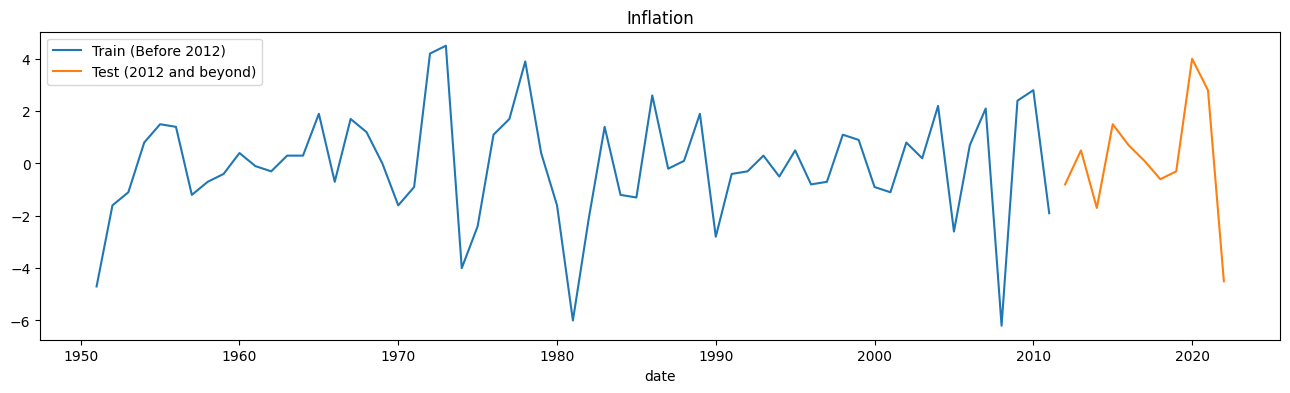

In [ ]:
tstart = 1951
tend = 2011

def train_test_plot(df, tstart, tend):
    df.loc[f"{tstart}":f"{tend}", "Y"].plot(figsize=(16, 4), legend=True)
    df.loc[f"{tend+1}":, "Y"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Inflation")
    plt.show()

train_test_plot(df,tstart,tend)

In [ ]:
## 3. Data Preprocessing

The train_test_split function divides the dataset into two subsets: training_set and test_set.

In [ ]:
def train_test_split(df, tstart, tend):
    train = df.loc[f"{tstart}":f"{tend}", "Y"].values
    test = df.loc[f"{tend+1}":, "Y"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

We will use the MinMaxScaler function to standardize our training set, which will help us avoid the outliers or anomalies.

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 10
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

print(X_train)


NameError: name 'training_set_scaled' is not defined

We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

In [ ]:
# Reshaping X_train for model
# Assuming 'features' is a predefined variable representing the number of features
# Adjusted to handle cases where X_train originally has less than 2 dimensions
if len(X_train.shape) < 2:
    # If X_train has only one dimension, reshape it accordingly
    X_train = X_train.reshape(X_train.shape[0], 1, features)
else:
    # If X_train has two or more dimensions, use the original reshape logic
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

The model consists of a single hidden layer of LSTM and an output layer. For this experiment, we will set LSTM units to 125, tanh as activation, and set input size.

Tensorflow library is user-friendly, so we don't have to create LSTM or GRU models from scratch. We will simply use the LSTM to construct the model.

Finally, we will compile the model with an RMSprop optimizer and mean square error as a loss function.

## Why LSTM?

The Long Short Term Memory (LSTM) is the advanced type of RNN, which was designed to prevent both decaying and exploding gradient problems. Just like RNN, LSTM has repeating modules, but the structure is different. Instead of having a single layer of tanh, LSTM has four interacting layers that communicate with each other. This four-layered structure helps LSTM retain long-term memory and can be used in stock prediction. The LSTM has the ability to triage the impact patterns from different categories of events and take inputs with different lengths, which is useful when LSTM is used to build general forecasting models for specific customers or industries.

Therefore, I decided to try to use the RNN LSTM model to forecast inflation.

## 4. Model Training

In [ ]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 125)               63500     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
2/2 [==============================] - 2s 16ms/step - loss: 0.3054
Epoch 2/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0824
Epoch 3/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0440
Epoch 4/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0437
Epoch 5/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0470
Epoch 6/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0438
Epoch 7/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0482
Epoch 8/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0435
Epoch 9/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0444
Epoch 10/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0434
Epoch 11/50
2/2 [==============================] - 0s 9ms/step - loss: 0.0439
Epoch 12/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0608
Epoch 13/50
2/2 [==============================] - 0s 8ms/step - los

In [ ]:
X_test.shape

(0,)

In [ ]:
inputs = df[len(df) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_inflation = model_lstm.predict(X_test)
#inverse transform the values
predicted_inflation = sc.inverse_transform(predicted_inflation)

1/1 [==============================] - 0s 358ms/step


In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Inflation Prediction")
    plt.xlabel("Time")
    plt.ylabel("Inflation")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

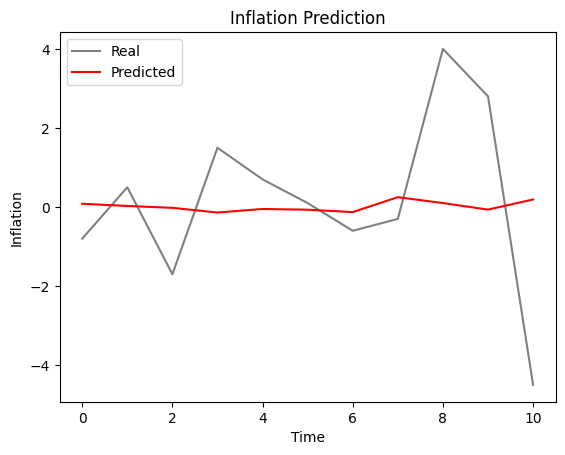

In [ ]:
plot_predictions(test_set,predicted_inflation)

In [ ]:
return_rmse(test_set,predicted_inflation)

The root mean squared error is 2.20.


In [ ]:
print(predicted_inflation)

[[ 0.08311638]
 [ 0.0269665 ]
 [-0.02005371]
 [-0.13882683]
 [-0.04880437]
 [-0.0674891 ]
 [-0.12811422]
 [ 0.24966037]
 [ 0.10078515]
 [-0.06504581]
 [ 0.1915806 ]]


In [ ]:
rw_prediction=np.zeros(predicted_inflation.size)
return_rmse(test_set,rw_prediction)



The root mean squared error is 2.15.


Unfortunately, a Recurrent Neural Network (RNN) using Long Short Term Memory (LSTM) is not as effective in predicting inflation. It is suggested to use Random Forrest or Regression instead (https://app.datacamp.com/workspace/w/f7917c05-f30d-449d-a0aa-c8396a32417c/edit).

While long short-term memory (LSTM) recurrent neural networks (RNNs) can be effective in many prediction tasks, there are several reasons why they may not be well-suited for predicting inflation.

LSTM models are often considered "black box" models, meaning it can be challenging to interpret the factors or variables that contribute to their predictions. In the case of inflation, it is important to understand the economic factors and indicators that drive inflation rates. LSTM models may not provide insights into the underlying economic dynamics affecting inflation.

Inflation is influenced by a complex interplay of various macroeconomic factors, such as fiscal policy, monetary policy, labor market conditions, and supply and demand dynamics. LSTM models, while powerful in capturing short-term dependencies, may struggle to effectively incorporate and model these macroeconomic factors that drive inflation over longer time horizons.

LSTM models typically require a significant amount of historical data to learn and generalize patterns effectively. However, inflation data may be relatively scarce, especially for long-term historical periods. Limited data availability can hinder the training and performance of LSTM models, particularly when trying to capture long-term inflation trends.

Inflation is influenced by both linear and non-linear relationships among various economic factors. LSTM models can capture some non-linear patterns, but their effectiveness may vary depending on the complexity and nature of the relationships involved. In some cases, alternative modeling techniques, such as econometric models or time series analysis, may be more suitable for capturing non-linear relationships in inflation data.

Inflation dynamics can undergo structural changes over time, such as changes in monetary policy regimes or shifts in economic conditions. LSTM models may struggle to adapt to such structural changes, especially if the training data does not adequately represent these shifts. Incorporating regime-dependent models or explicitly accounting for regime shifts might be necessary to improve inflation predictions.

It's important to note that while LSTM models may have limitations in predicting inflation, they can still be useful in certain contexts or when combined with other modeling approaches. The suitability of a particular technique depends on the specific characteristics of the data, the availability of relevant features, and the problem's complexity.

# Future Research

Attempting a GRU model (another type of Reurrent Neural Network) is a possible point for future research. A "GRU" model, short for "Gated Recurrent Unit," is a type of recurrent neural network (RNN) architecture. It was introduced by Kyunghyun Cho et al. in 2014 as a variation of the traditional RNN model.

Like other RNNs, the GRU model is designed to process sequential data, such as time series or language sequences, by maintaining an internal hidden state that captures information from previous steps. However, the GRU introduces gating mechanisms that allow it to selectively update and reset its hidden state, enabling more effective information flow and addressing some of the limitations of traditional RNNs.

The main components of a GRU unit are an update gate and a reset gate. The update gate determines the extent to which the previous hidden state is combined with the current input, while the reset gate controls how much of the previous hidden state is forgotten. These gates are trained during the learning process and help the GRU model capture long-term dependencies and mitigate the vanishing gradient problem often encountered in RNNs.

GRU models have gained popularity in various natural language processing (NLP) tasks, such as language translation, sentiment analysis, and text generation. They have also been applied in other domains, including speech recognition, image captioning, and time series forecasting.

Overall, the GRU model provides a computationally efficient and effective approach for modeling sequential data by incorporating gating mechanisms that enable better information retention and flow.